<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [GTSRB3] - Training monitoring
<!-- DESC --> Episode 3 : Monitoring, analysis and check points during a training session
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
  - **Understand** what happens during the **training** process
  - Implement **monitoring**, **backup** and **recovery** solutions
  
The German Traffic Sign Recognition Benchmark (GTSRB) is a dataset with more than 50,000 photos of road signs from about 40 classes.  
The final aim is to recognise them !  
Description is available there : http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset

## What we're going to do :

 - Monitoring and understanding our model training 
 - Add recovery points
 - Analyze the results 
 - Restore and run recovery points

## Step 1 - Import and init
### 1.1 - Python stuffs

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import h5py

from sklearn.metrics import confusion_matrix
from skimage import io, transform, color

import matplotlib.pyplot as plt
import os, sys, time, random

from importlib import reload

sys.path.append('..')
import fidle.pwk as pwk

run_dir = './run/GTSRB3.001'
datasets_dir = pwk.init('GTSRB3', run_dir)

**\*\* Overrided parameters : \*\***

run_dir              : ./run/GTSRB3_done


<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.7
Notebook id          : GTSRB3
Run time             : Wednesday 27 January 2021, 18:28:02
TensorFlow version   : 2.2.0
Keras version        : 2.3.0-tf
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run/GTSRB3_done
Update keras cache   : False
Save figs            : True
Path figs            : ./run/GTSRB3_done/figs


### 1.2 - Parameters
`scale` is the proportion of the dataset that will be used during the training. (1 mean 100%)  
A 24x24 dataset, with 5 epochs and a scale of 1, need  3'30 on a CPU laptop.

In [2]:
enhanced_dir = f'{datasets_dir}/GTSRB/enhanced'
dataset_name = 'set-24x24-L'
batch_size   = 64
epochs       = 5
scale        = 1

# enhanced_dir = './data'

Override parameters (batch mode) - Just forget this cell

In [3]:
pwk.override('enhanced_dir', 'dataset_name', 'batch_size', 'epochs', 'scale')

**\*\* Overrided parameters : \*\***

enhanced_dir         : /gpfswork/rech/mlh/uja62cb/datasets/GTSRB/enhanced
dataset_name         : set-24x24-L
batch_size           : 64
epochs               : 5
scale                : 1


## Step 2 - Load dataset
Dataset is one of the saved dataset: RGB25, RGB35, L25, L35, etc.  
First of all, we're going to use a smart dataset : **set-24x24-L**  
(with a GPU, it only takes 35'' compared to more than 5' with a CPU !)

In [4]:
def read_dataset(enhanced_dir, dataset_name):
    '''Reads h5 dataset
    Args:
        filename     : datasets filename
        dataset_name : dataset name, without .h5
    Returns:    x_train,y_train, x_test,y_test data, x_meta,y_meta'''
    # ---- Read dataset
    pwk.chrono_start()
    filename = f'{enhanced_dir}/{dataset_name}.h5'
    with  h5py.File(filename,'r') as f:
        x_train = f['x_train'][:]
        y_train = f['y_train'][:]
        x_test  = f['x_test'][:]
        y_test  = f['y_test'][:]
        x_meta  = f['x_meta'][:]
        y_meta  = f['y_meta'][:]
    print(x_train.shape, y_train.shape)
    # ---- Shuffle
    x_train,y_train=pwk.shuffle_np_dataset(x_train,y_train)

    # ---- done
    duration = pwk.chrono_stop(hdelay=True)
    size     = pwk.hsize(os.path.getsize(filename))
    print(f'Dataset "{dataset_name}" is loaded and shuffled. ({size} in {duration})')
    return x_train,y_train, x_test,y_test, x_meta,y_meta

# ---- Read dataset
#
x_train,y_train,x_test,y_test, x_meta,y_meta = read_dataset(enhanced_dir, dataset_name)

# ---- Rescale 
#
x_train,y_train, x_test,y_test = pwk.rescale_dataset(x_train,y_train,x_test,y_test, scale=scale)

(39209, 24, 24, 1) (39209,)
Dataset "set-24x24-L" is loaded and shuffled. (228.8 Mo in 00:00:00 163ms)


## Step 3 - Have a look to the dataset
Note: Data must be reshape for matplotlib

x_train : 

 (39209, 24, 24, 1)
y_train :  (39209,)
x_test  :  (12630, 24, 24, 1)
y_test  :  (12630,)


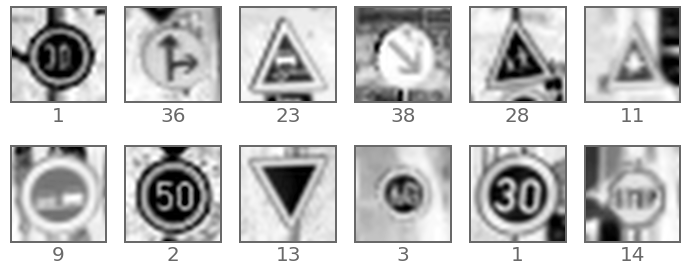

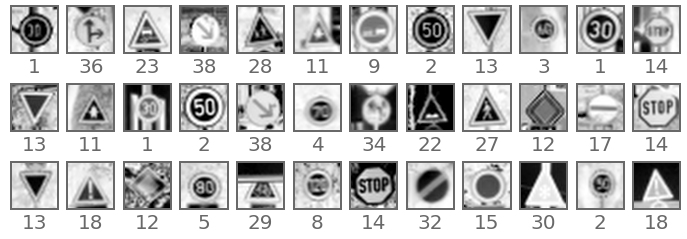

In [5]:
print("x_train : ", x_train.shape)
print("y_train : ", y_train.shape)
print("x_test  : ", x_test.shape)
print("y_test  : ", y_test.shape)

pwk.plot_images(x_train, y_train, range(12), columns=6,  x_size=2, y_size=2, save_as='01-dataset-medium')
pwk.plot_images(x_train, y_train, range(36), columns=12, x_size=1, y_size=1, save_as='02-dataset-small')

## Step 4 - Create model
We will now build a model and train it...

Some models... 

In [6]:
# A basic model
#
def get_model_v1(lx,ly,lz):
    
    model = keras.models.Sequential()
    
    model.add( keras.layers.Conv2D(96, (3,3), activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(192, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1500, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(43, activation='softmax'))
    return model


## Step 5 - Prepare callbacks  
We will add 2 callbacks :  

**TensorBoard**  
Training logs, which can be visualised using [Tensorboard tool](https://www.tensorflow.org/tensorboard).  

**Model backup**  
 It is possible to save the model each xx epoch or at each improvement.  
 The model can be saved completely or partially (weight).  
 For full format, we can use HDF5 format.

In [7]:
pwk.mkdir(run_dir + '/models')
pwk.mkdir(run_dir + '/logs')

# ---- Callback tensorboard
log_dir = run_dir + "/logs/tb_" + pwk.tag_now()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# ---- Callback ModelCheckpoint - Save best model
save_dir = run_dir + "/models/best-model.h5"
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, monitor='accuracy', save_best_only=True)

# ---- Callback ModelCheckpoint - Save model each epochs
save_dir = run_dir + "/models/model-{epoch:04d}.h5"
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0)

print(f'To run tensorboard, use :  --logdir {run_dir}/logs')

To run tensorboard, use :  --logdir ./run/GTSRB3_done/logs


## Step 6 - Train the model
**Get the shape of my data :**

In [8]:
(n,lx,ly,lz) = x_train.shape
print("Images of the dataset have this folowing shape : ",(lx,ly,lz))

Images of the dataset have this folowing shape :  (24, 24, 1)


**Get and compile a model, with the data shape :**

In [9]:
model = get_model_v1(lx,ly,lz)

# model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

**Train it :**  
Note: The training curve is visible in real time with Tensorboard (see step  5)

In [10]:
pwk.chrono_start()

# ---- Shuffle train data
x_train,y_train=pwk.shuffle_np_dataset(x_train,y_train)

# ---- Train
# Note: To be faster in our example, we can take only 2000 values
#
history = model.fit(  x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(x_test, y_test),
                      callbacks=[tensorboard_callback, bestmodel_callback, savemodel_callback] )

model.save(f'{run_dir}/models/last-model.h5')

pwk.chrono_show()

Epoch 1/5


  1/613 [..............................] - ETA: 0s - loss: 3.7705 - accuracy: 0.0312

  3/613 [..............................] - ETA: 10s - loss: 3.6841 - accuracy: 0.0469

 18/613 [..............................] - ETA: 3s - loss: 3.6131 - accuracy: 0.0530 

 33/613 [>.............................] - ETA: 2s - loss: 3.5661 - accuracy: 0.0601

 49/613 [=>............................] - ETA: 2s - loss: 3.5179 - accuracy: 0.0727

 65/613 [==>...........................] - ETA: 2s - loss: 3.4461 - accuracy: 0.0952

 81/613 [==>...........................] - ETA: 2s - loss: 3.3571 - accuracy: 0.1200

 97/613 [===>..........................] - ETA: 1s - loss: 3.2414 - accuracy: 0.1500

113/613 [====>.........................] - ETA: 1s - loss: 3.1154 - accuracy: 0.1789

129/613 [=====>........................] - ETA: 1s - loss: 2.9730 - accuracy: 0.2154

145/613 [======>.......................] - ETA: 1s - loss: 2.8415 - accuracy: 0.2452

161/613 [======>.......................] - ETA: 1s - loss: 2.7071 - accuracy: 0.2785

177/613 [=======>......................] - ETA: 1s - loss: 2.5861 - accuracy: 0.3081

193/613 [========>.....................] - ETA: 1s - loss: 2.4716 - accuracy: 0.3365

209/613 [=========>....................] - ETA: 1s - loss: 2.3731 - accuracy: 0.3601

225/613 [==========>...................] - ETA: 1s - loss: 2.2775 - accuracy: 0.3842

241/613 [==========>...................] - ETA: 1s - loss: 2.1883 - accuracy: 0.4063

257/613 [===========>..................] - ETA: 1s - loss: 2.1109 - accuracy: 0.4256

273/613 [============>.................] - ETA: 1s - loss: 2.0360 - accuracy: 0.4446

289/613 [=============>................] - ETA: 1s - loss: 1.9687 - accuracy: 0.4620

305/613 [=============>................] - ETA: 1s - loss: 1.9034 - accuracy: 0.4786

321/613 [==============>...............] - ETA: 0s - loss: 1.8415 - accuracy: 0.4948

337/613 [===============>..............] - ETA: 0s - loss: 1.7866 - accuracy: 0.5093

353/613 [================>.............] - ETA: 0s - loss: 1.7341 - accuracy: 0.5234

369/613 [=================>............] - ETA: 0s - loss: 1.6841 - accuracy: 0.5370

385/613 [=================>............] - ETA: 0s - loss: 1.6383 - accuracy: 0.5491

401/613 [==================>...........] - ETA: 0s - loss: 1.5928 - accuracy: 0.5614

417/613 [===================>..........] - ETA: 0s - loss: 1.5518 - accuracy: 0.5724

433/613 [====================>.........] - ETA: 0s - loss: 1.5130 - accuracy: 0.5834

449/613 [====================>.........] - ETA: 0s - loss: 1.4759 - accuracy: 0.5935

465/613 [=====================>........] - ETA: 0s - loss: 1.4406 - accuracy: 0.6025

481/613 [======================>.......] - ETA: 0s - loss: 1.4064 - accuracy: 0.6122

497/613 [=======================>......] - ETA: 0s - loss: 1.3749 - accuracy: 0.6208

513/613 [========================>.....] - ETA: 0s - loss: 1.3444 - accuracy: 0.6292

529/613 [========================>.....] - ETA: 0s - loss: 1.3159 - accuracy: 0.6368

545/613 [=========================>....] - ETA: 0s - loss: 1.2875 - accuracy: 0.6444

561/613 [==========================>...] - ETA: 0s - loss: 1.2622 - accuracy: 0.6513

577/613 [===========================>..] - ETA: 0s - loss: 1.2380 - accuracy: 0.6578

593/613 [============================>.] - ETA: 0s - loss: 1.2146 - accuracy: 0.6641

609/613 [============================>.] - ETA: 0s - loss: 1.1929 - accuracy: 0.6699

613/613 [==============================] - 3s 5ms/step - loss: 1.1880 - accuracy: 0.6713 - val_loss: 0.4443 - val_accuracy: 0.8866


Epoch 2/5
  1/613 [..............................] - ETA: 0s - loss: 0.6590 - accuracy: 0.7969

 17/613 [..............................] - ETA: 1s - loss: 0.3339 - accuracy: 0.8925

 33/613 [>.............................] - ETA: 1s - loss: 0.3126 - accuracy: 0.9072

 49/613 [=>............................] - ETA: 1s - loss: 0.2998 - accuracy: 0.9129

 65/613 [==>...........................] - ETA: 1s - loss: 0.3030 - accuracy: 0.9123

 81/613 [==>...........................] - ETA: 1s - loss: 0.2913 - accuracy: 0.9172

 97/613 [===>..........................] - ETA: 1s - loss: 0.2822 - accuracy: 0.9199

113/613 [====>.........................] - ETA: 1s - loss: 0.2752 - accuracy: 0.9222

129/613 [=====>........................] - ETA: 1s - loss: 0.2747 - accuracy: 0.9230

145/613 [======>.......................] - ETA: 1s - loss: 0.2773 - accuracy: 0.9220

161/613 [======>.......................] - ETA: 1s - loss: 0.2752 - accuracy: 0.9232

177/613 [=======>......................] - ETA: 1s - loss: 0.2699 - accuracy: 0.9249

193/613 [========>.....................] - ETA: 1s - loss: 0.2694 - accuracy: 0.9241

209/613 [=========>....................] - ETA: 1s - loss: 0.2654 - accuracy: 0.9247

225/613 [==========>...................] - ETA: 1s - loss: 0.2672 - accuracy: 0.9239

241/613 [==========>...................] - ETA: 1s - loss: 0.2653 - accuracy: 0.9238

257/613 [===========>..................] - ETA: 1s - loss: 0.2628 - accuracy: 0.9243

273/613 [============>.................] - ETA: 1s - loss: 0.2591 - accuracy: 0.9250

289/613 [=============>................] - ETA: 1s - loss: 0.2608 - accuracy: 0.9244

305/613 [=============>................] - ETA: 0s - loss: 0.2591 - accuracy: 0.9249

321/613 [==============>...............] - ETA: 0s - loss: 0.2556 - accuracy: 0.9258

337/613 [===============>..............] - ETA: 0s - loss: 0.2537 - accuracy: 0.9267

353/613 [================>.............] - ETA: 0s - loss: 0.2514 - accuracy: 0.9272

369/613 [=================>............] - ETA: 0s - loss: 0.2486 - accuracy: 0.9278

385/613 [=================>............] - ETA: 0s - loss: 0.2457 - accuracy: 0.9289

401/613 [==================>...........] - ETA: 0s - loss: 0.2447 - accuracy: 0.9290

417/613 [===================>..........] - ETA: 0s - loss: 0.2427 - accuracy: 0.9296

433/613 [====================>.........] - ETA: 0s - loss: 0.2411 - accuracy: 0.9299

449/613 [====================>.........] - ETA: 0s - loss: 0.2398 - accuracy: 0.9305

465/613 [=====================>........] - ETA: 0s - loss: 0.2388 - accuracy: 0.9311

481/613 [======================>.......] - ETA: 0s - loss: 0.2371 - accuracy: 0.9317

497/613 [=======================>......] - ETA: 0s - loss: 0.2353 - accuracy: 0.9322

513/613 [========================>.....] - ETA: 0s - loss: 0.2343 - accuracy: 0.9327

529/613 [========================>.....] - ETA: 0s - loss: 0.2326 - accuracy: 0.9331

545/613 [=========================>....] - ETA: 0s - loss: 0.2313 - accuracy: 0.9337

561/613 [==========================>...] - ETA: 0s - loss: 0.2308 - accuracy: 0.9342

577/613 [===========================>..] - ETA: 0s - loss: 0.2294 - accuracy: 0.9345

593/613 [============================>.] - ETA: 0s - loss: 0.2275 - accuracy: 0.9350

609/613 [============================>.] - ETA: 0s - loss: 0.2254 - accuracy: 0.9356

613/613 [==============================] - 3s 5ms/step - loss: 0.2251 - accuracy: 0.9357 - val_loss: 0.3121 - val_accuracy: 0.9294


Epoch 3/5
  1/613 [..............................] - ETA: 0s - loss: 0.1793 - accuracy: 0.9688

 17/613 [..............................] - ETA: 1s - loss: 0.1239 - accuracy: 0.9651

 33/613 [>.............................] - ETA: 1s - loss: 0.1408 - accuracy: 0.9616

 49/613 [=>............................] - ETA: 1s - loss: 0.1445 - accuracy: 0.9633

 65/613 [==>...........................] - ETA: 1s - loss: 0.1446 - accuracy: 0.9613

 81/613 [==>...........................] - ETA: 1s - loss: 0.1442 - accuracy: 0.9610

 97/613 [===>..........................] - ETA: 1s - loss: 0.1452 - accuracy: 0.9615

113/613 [====>.........................] - ETA: 1s - loss: 0.1426 - accuracy: 0.9616

129/613 [=====>........................] - ETA: 1s - loss: 0.1403 - accuracy: 0.9618

145/613 [======>.......................] - ETA: 1s - loss: 0.1411 - accuracy: 0.9616

161/613 [======>.......................] - ETA: 1s - loss: 0.1358 - accuracy: 0.9634

177/613 [=======>......................] - ETA: 1s - loss: 0.1331 - accuracy: 0.9641

193/613 [========>.....................] - ETA: 1s - loss: 0.1328 - accuracy: 0.9643

209/613 [=========>....................] - ETA: 1s - loss: 0.1345 - accuracy: 0.9638

225/613 [==========>...................] - ETA: 1s - loss: 0.1342 - accuracy: 0.9635

241/613 [==========>...................] - ETA: 1s - loss: 0.1340 - accuracy: 0.9629

257/613 [===========>..................] - ETA: 1s - loss: 0.1327 - accuracy: 0.9634

273/613 [============>.................] - ETA: 1s - loss: 0.1326 - accuracy: 0.9635

289/613 [=============>................] - ETA: 1s - loss: 0.1321 - accuracy: 0.9634

305/613 [=============>................] - ETA: 0s - loss: 0.1311 - accuracy: 0.9633

321/613 [==============>...............] - ETA: 0s - loss: 0.1309 - accuracy: 0.9634

337/613 [===============>..............] - ETA: 0s - loss: 0.1295 - accuracy: 0.9637

353/613 [================>.............] - ETA: 0s - loss: 0.1297 - accuracy: 0.9633

369/613 [=================>............] - ETA: 0s - loss: 0.1285 - accuracy: 0.9635

385/613 [=================>............] - ETA: 0s - loss: 0.1283 - accuracy: 0.9636

401/613 [==================>...........] - ETA: 0s - loss: 0.1279 - accuracy: 0.9638

417/613 [===================>..........] - ETA: 0s - loss: 0.1279 - accuracy: 0.9639

433/613 [====================>.........] - ETA: 0s - loss: 0.1281 - accuracy: 0.9639

449/613 [====================>.........] - ETA: 0s - loss: 0.1277 - accuracy: 0.9638

465/613 [=====================>........] - ETA: 0s - loss: 0.1278 - accuracy: 0.9636

481/613 [======================>.......] - ETA: 0s - loss: 0.1270 - accuracy: 0.9639

497/613 [=======================>......] - ETA: 0s - loss: 0.1272 - accuracy: 0.9640

513/613 [========================>.....] - ETA: 0s - loss: 0.1267 - accuracy: 0.9638

529/613 [========================>.....] - ETA: 0s - loss: 0.1266 - accuracy: 0.9639

545/613 [=========================>....] - ETA: 0s - loss: 0.1267 - accuracy: 0.9639

561/613 [==========================>...] - ETA: 0s - loss: 0.1258 - accuracy: 0.9640

577/613 [===========================>..] - ETA: 0s - loss: 0.1248 - accuracy: 0.9641

593/613 [============================>.] - ETA: 0s - loss: 0.1251 - accuracy: 0.9641

609/613 [============================>.] - ETA: 0s - loss: 0.1250 - accuracy: 0.9642

613/613 [==============================] - 3s 5ms/step - loss: 0.1245 - accuracy: 0.9643 - val_loss: 0.2698 - val_accuracy: 0.9378


Epoch 4/5
  1/613 [..............................] - ETA: 0s - loss: 0.1249 - accuracy: 0.9688

 17/613 [..............................] - ETA: 1s - loss: 0.1005 - accuracy: 0.9706

 33/613 [>.............................] - ETA: 1s - loss: 0.0931 - accuracy: 0.9754

 49/613 [=>............................] - ETA: 1s - loss: 0.0996 - accuracy: 0.9716

 65/613 [==>...........................] - ETA: 1s - loss: 0.1007 - accuracy: 0.9714

 81/613 [==>...........................] - ETA: 1s - loss: 0.1059 - accuracy: 0.9705

 97/613 [===>..........................] - ETA: 1s - loss: 0.1053 - accuracy: 0.9705

113/613 [====>.........................] - ETA: 1s - loss: 0.1054 - accuracy: 0.9700

129/613 [=====>........................] - ETA: 1s - loss: 0.1078 - accuracy: 0.9695

145/613 [======>.......................] - ETA: 1s - loss: 0.1091 - accuracy: 0.9692

161/613 [======>.......................] - ETA: 1s - loss: 0.1053 - accuracy: 0.9705

177/613 [=======>......................] - ETA: 1s - loss: 0.1042 - accuracy: 0.9708

193/613 [========>.....................] - ETA: 1s - loss: 0.1020 - accuracy: 0.9717

209/613 [=========>....................] - ETA: 1s - loss: 0.1015 - accuracy: 0.9715

225/613 [==========>...................] - ETA: 1s - loss: 0.1011 - accuracy: 0.9715

241/613 [==========>...................] - ETA: 1s - loss: 0.0998 - accuracy: 0.9719

257/613 [===========>..................] - ETA: 1s - loss: 0.0999 - accuracy: 0.9722

273/613 [============>.................] - ETA: 1s - loss: 0.0984 - accuracy: 0.9725

289/613 [=============>................] - ETA: 1s - loss: 0.0972 - accuracy: 0.9726

305/613 [=============>................] - ETA: 0s - loss: 0.0987 - accuracy: 0.9722

321/613 [==============>...............] - ETA: 0s - loss: 0.0981 - accuracy: 0.9722

337/613 [===============>..............] - ETA: 0s - loss: 0.0970 - accuracy: 0.9723

353/613 [================>.............] - ETA: 0s - loss: 0.0964 - accuracy: 0.9725

369/613 [=================>............] - ETA: 0s - loss: 0.0957 - accuracy: 0.9724

385/613 [=================>............] - ETA: 0s - loss: 0.0954 - accuracy: 0.9724

401/613 [==================>...........] - ETA: 0s - loss: 0.0967 - accuracy: 0.9720

417/613 [===================>..........] - ETA: 0s - loss: 0.0958 - accuracy: 0.9722

433/613 [====================>.........] - ETA: 0s - loss: 0.0955 - accuracy: 0.9721

449/613 [====================>.........] - ETA: 0s - loss: 0.0946 - accuracy: 0.9724

465/613 [=====================>........] - ETA: 0s - loss: 0.0940 - accuracy: 0.9725

481/613 [======================>.......] - ETA: 0s - loss: 0.0931 - accuracy: 0.9729

497/613 [=======================>......] - ETA: 0s - loss: 0.0923 - accuracy: 0.9731

513/613 [========================>.....] - ETA: 0s - loss: 0.0925 - accuracy: 0.9731

529/613 [========================>.....] - ETA: 0s - loss: 0.0923 - accuracy: 0.9732

545/613 [=========================>....] - ETA: 0s - loss: 0.0928 - accuracy: 0.9729

561/613 [==========================>...] - ETA: 0s - loss: 0.0939 - accuracy: 0.9725

577/613 [===========================>..] - ETA: 0s - loss: 0.0934 - accuracy: 0.9727

593/613 [============================>.] - ETA: 0s - loss: 0.0931 - accuracy: 0.9727

609/613 [============================>.] - ETA: 0s - loss: 0.0933 - accuracy: 0.9726

613/613 [==============================] - 3s 5ms/step - loss: 0.0934 - accuracy: 0.9726 - val_loss: 0.2612 - val_accuracy: 0.9319


Epoch 5/5
  1/613 [..............................] - ETA: 0s - loss: 0.1039 - accuracy: 0.9844

 17/613 [..............................] - ETA: 1s - loss: 0.0875 - accuracy: 0.9697

 33/613 [>.............................] - ETA: 1s - loss: 0.0741 - accuracy: 0.9749

 49/613 [=>............................] - ETA: 1s - loss: 0.0703 - accuracy: 0.9780

 65/613 [==>...........................] - ETA: 1s - loss: 0.0687 - accuracy: 0.9786

 81/613 [==>...........................] - ETA: 1s - loss: 0.0679 - accuracy: 0.9782

 97/613 [===>..........................] - ETA: 1s - loss: 0.0717 - accuracy: 0.9763

113/613 [====>.........................] - ETA: 1s - loss: 0.0697 - accuracy: 0.9769

129/613 [=====>........................] - ETA: 1s - loss: 0.0672 - accuracy: 0.9781

145/613 [======>.......................] - ETA: 1s - loss: 0.0660 - accuracy: 0.9782

161/613 [======>.......................] - ETA: 1s - loss: 0.0649 - accuracy: 0.9783

177/613 [=======>......................] - ETA: 1s - loss: 0.0632 - accuracy: 0.9787

193/613 [========>.....................] - ETA: 1s - loss: 0.0637 - accuracy: 0.9789

209/613 [=========>....................] - ETA: 1s - loss: 0.0652 - accuracy: 0.9782

225/613 [==========>...................] - ETA: 1s - loss: 0.0659 - accuracy: 0.9781

241/613 [==========>...................] - ETA: 1s - loss: 0.0669 - accuracy: 0.9782

257/613 [===========>..................] - ETA: 1s - loss: 0.0672 - accuracy: 0.9784

273/613 [============>.................] - ETA: 1s - loss: 0.0686 - accuracy: 0.9779

289/613 [=============>................] - ETA: 1s - loss: 0.0698 - accuracy: 0.9777

305/613 [=============>................] - ETA: 0s - loss: 0.0687 - accuracy: 0.9781

321/613 [==============>...............] - ETA: 0s - loss: 0.0679 - accuracy: 0.9786

337/613 [===============>..............] - ETA: 0s - loss: 0.0674 - accuracy: 0.9790

353/613 [================>.............] - ETA: 0s - loss: 0.0670 - accuracy: 0.9792

369/613 [=================>............] - ETA: 0s - loss: 0.0667 - accuracy: 0.9792

385/613 [=================>............] - ETA: 0s - loss: 0.0670 - accuracy: 0.9792

401/613 [==================>...........] - ETA: 0s - loss: 0.0666 - accuracy: 0.9794

417/613 [===================>..........] - ETA: 0s - loss: 0.0667 - accuracy: 0.9793

433/613 [====================>.........] - ETA: 0s - loss: 0.0662 - accuracy: 0.9795

449/613 [====================>.........] - ETA: 0s - loss: 0.0664 - accuracy: 0.9796

465/613 [=====================>........] - ETA: 0s - loss: 0.0668 - accuracy: 0.9794

481/613 [======================>.......] - ETA: 0s - loss: 0.0674 - accuracy: 0.9791

497/613 [=======================>......] - ETA: 0s - loss: 0.0677 - accuracy: 0.9791

513/613 [========================>.....] - ETA: 0s - loss: 0.0686 - accuracy: 0.9790

529/613 [========================>.....] - ETA: 0s - loss: 0.0689 - accuracy: 0.9791

545/613 [=========================>....] - ETA: 0s - loss: 0.0689 - accuracy: 0.9791

561/613 [==========================>...] - ETA: 0s - loss: 0.0692 - accuracy: 0.9790

577/613 [===========================>..] - ETA: 0s - loss: 0.0687 - accuracy: 0.9791

593/613 [============================>.] - ETA: 0s - loss: 0.0696 - accuracy: 0.9788

609/613 [============================>.] - ETA: 0s - loss: 0.0697 - accuracy: 0.9789

613/613 [==============================] - 3s 5ms/step - loss: 0.0696 - accuracy: 0.9789 - val_loss: 0.2283 - val_accuracy: 0.9457



Duration :  00:00:18 448ms


**Evaluate it :**

In [11]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.9457


In [12]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.2283
Test accuracy  : 0.9457


## Step 7 - History
The return of model.fit() returns us the learning history

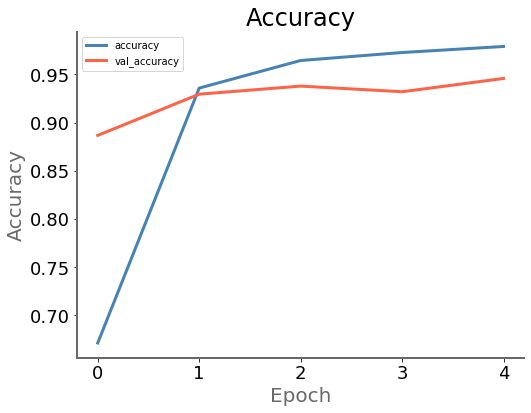

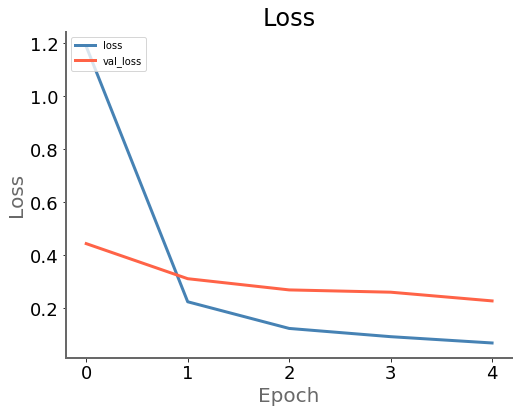

In [13]:
pwk.plot_history(history, save_as='03-history')

## Step 8 - Evaluation and confusion

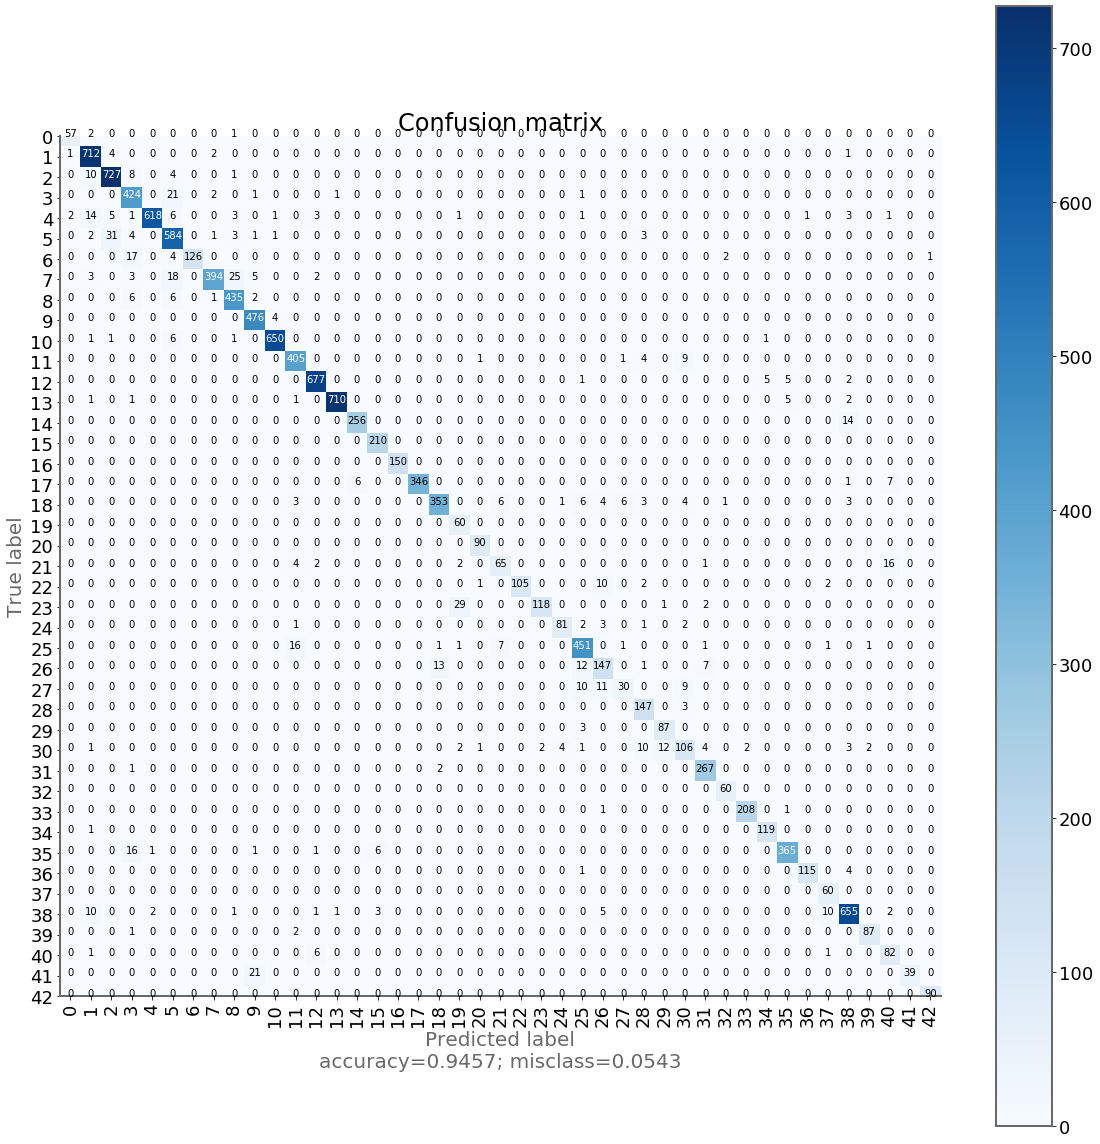

In [14]:
y_sigmoid = model.predict(x_test)
y_pred    = np.argmax(y_sigmoid, axis=-1)

pwk.plot_confusion_matrix(y_test,y_pred,range(43), figsize=(16, 16),normalize=False, save_as='04-confusion-matrix')

## Step 9 - Restore and evaluate
### 9.1 - List saved models :

In [15]:
!find "$run_dir"/models/

./run/GTSRB3_done/models/
./run/GTSRB3_done/models/last-model.h5
./run/GTSRB3_done/models/model-0002.h5
./run/GTSRB3_done/models/model-0004.h5
./run/GTSRB3_done/models/best-model.h5
./run/GTSRB3_done/models/model-0005.h5
./run/GTSRB3_done/models/model-0001.h5
./run/GTSRB3_done/models/model-0003.h5


### 9.2 - Restore a model :

In [16]:
loaded_model = tf.keras.models.load_model(f'{run_dir}/models/best-model.h5')
# loaded_model.summary()
print("Loaded.")

Loaded.


### 9.3 - Evaluate it :

In [17]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.2283
Test accuracy  : 0.9457


### 9.4 - Make a prediction :


Output layer from model is (x100) :

[[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   99.99]]

Graphically :



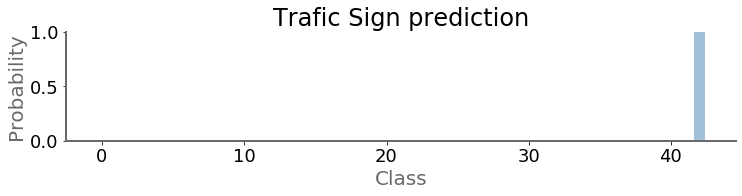


The image :               Prediction :            Real stuff:


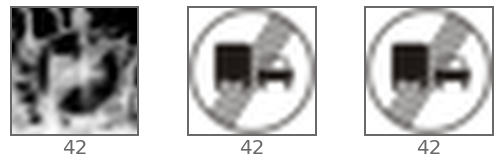

YEEES ! that's right!


In [18]:
# ---- Get a random image
#
i   = random.randint(1,len(x_test))
x,y = x_test[i], y_test[i]

# ---- Do prediction
#
predictions = loaded_model.predict( np.array([x]) )

# ---- A prediction is just the output layer
#
print("\nOutput layer from model is (x100) :\n")
with np.printoptions(precision=2, suppress=True, linewidth=95):
    print(predictions*100)

# ---- Graphic visualisation
#
print("\nGraphically :\n")
plt.figure(figsize=(12,2))
plt.bar(range(43), predictions[0], align='center', alpha=0.5)
plt.ylabel('Probability')
plt.ylim((0,1))
plt.xlabel('Class')
plt.title('Trafic Sign prediction')
pwk.save_fig('05-prediction-proba')
plt.show()

# ---- Predict class
#
p = np.argmax(predictions)

# ---- Show result
#
print("\nThe image :               Prediction :            Real stuff:")
pwk.plot_images([x,x_meta[p], x_meta[y]], [p,p,y], range(3),  columns=3,  x_size=3, y_size=2, save_as='06-prediction-images')

if p==y:
    print("YEEES ! that's right!")
else:
    print("oups, that's wrong ;-(")

In [19]:
pwk.end()

End time is : Wednesday 27 January 2021, 18:28:50
Duration is : 00:00:48 813ms
This notebook ends here


<div class="todo">
     What you can do:
    <ul>
        <li>Limit model saving: 1 save every 5 epochs </li>
        <li>Use a subset of the dataset</li>
        <li>Try different datasets</li>
        <li>Some exotic signs are waiting to be recognized in dataset_dir/extra !</li>
        <li>Test different hyperparameters (epochs, batch size, optimization, etc.)</li>
    </ul>
    
</div>

---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>